# Семинар по свёрточным нейросетям

## Скачать и распаковать датасет

Выполните эти ячейки чтобы скачать и отсортировать датасет

In [0]:
import shutil
import re
import os

In [0]:
#!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
#!unzip -qq Cat_Dog_data.zip

In [0]:
!pip install kaggle
!echo '{"username":"you_name","key":"1234567"}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 74.8MB/s]
 98% 265M/271M [00:02<00:00, 118MB/s]
100% 271M/271M [00:02<00:00, 110MB/s]
100% 543M/543M [00:06<00:00, 88.1MB/s]



In [0]:
!unzip -qq ./train.zip -d ./data

In [0]:
!mkdir -p ./data/train
!mkdir -p ./data/val
!mkdir -p ./data/train/cats
!mkdir -p ./data/train/dogs
!mkdir -p ./data/val/dogs
!mkdir -p ./data/val/cats

In [0]:
import os, re, shutil
input_dir = "./data/train"
files = os.listdir(input_dir)
train_cats_dir = "./data/train/cats"
train_dogs_dir = "./data/train/dogs"
val_cats_dir = "./data/val/cats"
val_dogs_dir = "./data/val/dogs"

# Move all train cat images to cats folder, dog images to dogs folder
for f in files:
    catSearchObj = re.search("cat", f)
    dogSearchObj = re.search("dog", f)
    if catSearchObj:
        shutil.move( input_dir + '/' + f, train_cats_dir)
    elif dogSearchObj:
        shutil.move(input_dir + '/' + f, train_dogs_dir)

In [0]:
files = os.listdir(train_dogs_dir)

for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(train_dogs_dir + '/' + f, val_dogs_dir)

files = os.listdir(train_cats_dir)

for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(train_cats_dir + '/' + f, val_cats_dir)

Если бы мы отправляли решение на проверку в kaggle, нам нужно было бы распаковать и тестовые образцы тоже, и написать немного кода: см. https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-2-inferencing-and-submitting-b5810b4dda96

In [0]:
# !mv ../input/dogs-vs-cats-for-pytorch/test1/* ./data/test

Если вы не зарегистрированы в kaggle, можно скачать датасет,  например, с udacity

In [0]:
#!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
#!unzip -qq Cat_Dog_data.zip

# Функции для загрузки, подготовки и аугментации данных

Позаимствовано с https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, math, copy

print(torch.__version__)
plt.ion()   # interactive mode

1.0.1.post2


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = './data'
CHECK_POINT_PATH = 'checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names) # => ['cats', 'dogs']
print('Train image size: ', dataset_sizes["train"])
print('Validation image size: ', dataset_sizes["val"])

['cats', 'dogs']
Train image size:  23000
Validation image size:  2000


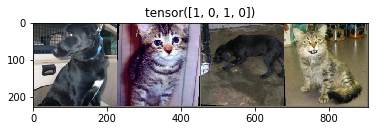

In [51]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=str(classes))

## Функции, которые реализуют обучение модели

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print('Val loss: ', checkpoint["best_val_loss"], ', Val accuracy: ', checkpoint["best_val_accuracy"])
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('New best model found!')
                print('New record loss: ', epoch_loss, ', previous record loss: ', best_loss)
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

## Функция для визуализации модели

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

# Реализация №1: Полносвязанная сеть

Попробуйте запустить и посмотрите на точность предсказаний...

In [0]:
# Convolutional neural network (two convolutional layers)
class FCNet(nn.Module):
    def __init__(self, num_classes=2):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model_fc = FCNet()

In [0]:
model_fc = model_fc.to(device)
criterion_fc = nn.CrossEntropyLoss()
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)

In [0]:
model_fc, best_val_loss, best_val_acc = train_model(model_fc,
                                                    criterion_fc,
                                                    optimizer_fc,
                                                    exp_lr_scheduler,
                                                    num_epochs = 3,
                                                    checkpoint = None)

torch.save({'model_state_dict': model_fc.state_dict(),
            'optimizer_state_dict': optimizer_fc.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

# Реализация №2: Набросок для конволюции

Попробуйте создать сеть, которая будет иметь точность предсказания больше 70%

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, ???, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #########################
        # ...
        # Допишите сюда ваши слои
        # ...
        #########################
        self.fc = nn.Linear( ??? * ??? *32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #########################
        # ...
        # Допишите сюда ваши слои
        # ...
        #########################
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        #print(out.shape)
        return out

model_conv = ConvNet()

## Пример решения (около 60%)

### Описание сети

### Отправить модель на GPU и объявить подробности решения

In [0]:
model_conv = model_conv.to(device)
criterion_conv = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Запустить решение сети

In [0]:
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion_conv,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = None)

torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

Epoch 0/2
----------
[1, 199] loss: 0.711
[1, 399] loss: 0.700
[1, 599] loss: 0.689
[1, 799] loss: 0.681
[1, 999] loss: 0.677
[1, 1199] loss: 0.669
[1, 1399] loss: 0.664
[1, 1599] loss: 0.660
[1, 1799] loss: 0.658
[1, 1999] loss: 0.655
[1, 2199] loss: 0.653
[1, 2399] loss: 0.652
[1, 2599] loss: 0.647
[1, 2799] loss: 0.644
[1, 2999] loss: 0.643
[1, 3199] loss: 0.641
[1, 3399] loss: 0.636
[1, 3599] loss: 0.633
[1, 3799] loss: 0.631
[1, 3999] loss: 0.630
[1, 4199] loss: 0.628
[1, 4399] loss: 0.626
[1, 4599] loss: 0.625
[1, 4799] loss: 0.623
[1, 4999] loss: 0.621
[1, 5199] loss: 0.618
[1, 5399] loss: 0.618
[1, 5599] loss: 0.616
train Loss: 0.6156 Acc: 0.6649
[1, 199] loss: 0.550
[1, 399] loss: 0.566
val Loss: 0.5705 Acc: 0.7130
New best model found!
New record loss:  0.5704694714248181 , previous record loss:  inf
Epoch 1/2
----------
[2, 199] loss: 0.550
[2, 399] loss: 0.535
[2, 599] loss: 0.540
[2, 799] loss: 0.554
[2, 999] loss: 0.556
[2, 1199] loss: 0.558
[2, 1399] loss: 0.563
[2, 1599

### Посмотреть предсказания сети

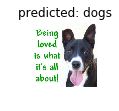

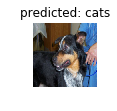

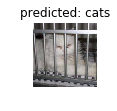

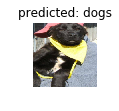

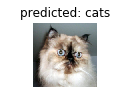

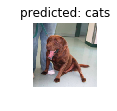

In [53]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=3),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=5, stride=3, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(56*56*4, num_classes)
        
    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out

model_conv = ConvNet()

# ResNet50

In [0]:
# model_resnet = torchvision.models.resnet50(pretrained=True)

In [0]:
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_resnet = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

In [0]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

model_resnet, best_val_loss, best_val_acc = train_model(model_resnet,
                                                      criterion,
                                                      optimizer_resnet,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)

torch.save({'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer_resnet.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

In [0]:
for param in model_resnet.parameters():
    param.requires_grad = True

model_resnet = model_resnet.to(device)

# Observe that all parameters are being optimized
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

# Валидация

In [0]:
visualize_model(model_resnet)

plt.ioff()
plt.show()